## Assignment 1
### Name:
### Roll Number:

In [1]:
# import all the necessary libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
df = pd.read_csv('../../dataset/decision-tree.csv')
print(df.shape) 

(768, 9)


In [3]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature  # Index of the feature to split on
        self.threshold = threshold  # Threshold value for the split
        self.left = left  # Left subtree
        self.right = right  # Right subtree
        self.value = value  # Class label (for leaf nodes)

In [4]:
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))

In [5]:
def information_gain(X, y, feature, threshold):
    left_indices = X[:, feature] <= threshold
    right_indices = ~left_indices

    num_left, num_right = len(y[left_indices]), len(y[right_indices])
    total_samples = num_left + num_right

    if num_left == 0 or num_right == 0:
        return 0  # Avoid division by zero

    left_entropy = entropy(y[left_indices])
    right_entropy = entropy(y[right_indices])

    weight_left = num_left / total_samples
    weight_right = num_right / total_samples

    weighted_avg_entropy = weight_left * left_entropy + weight_right * right_entropy

    parent_entropy = entropy(y)
    information_gain = parent_entropy - weighted_avg_entropy

    return information_gain

In [6]:
def id3(X, y, depth=0, max_depth=5, min_samples_split=2):
    num_samples, num_features = X.shape
    if depth >= max_depth or num_samples < min_samples_split or len(np.unique(y)) == 1:
        unique_classes, class_counts = np.unique(y, return_counts=True)
        most_common_class = unique_classes[np.argmax(class_counts)]
        return Node(value=most_common_class)

    best_feature, best_threshold = None, None
    max_info_gain = -1

    for feature in range(num_features):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            info_gain = information_gain(X, y, feature, threshold)
            if info_gain > max_info_gain:
                max_info_gain = info_gain
                best_feature = feature
                best_threshold = threshold

    if max_info_gain == 0:
        unique_classes, class_counts = np.unique(y, return_counts=True)
        most_common_class = unique_classes[np.argmax(class_counts)]
        return Node(value=most_common_class)

    left_indices = X[:, best_feature] <= best_threshold
    right_indices = X[:, best_feature] > best_threshold

    left_subtree = id3(X[left_indices], y[left_indices], depth + 1, max_depth, min_samples_split)
    right_subtree = id3(X[right_indices], y[right_indices], depth + 1, max_depth, min_samples_split)

    return Node(feature=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree)

In [7]:
def predict_tree(node, X):
    if node.value is not None:
        return node.value
    if X[node.feature] <= node.threshold:
        return predict_tree(node.left, X)
    else:
        return predict_tree(node.right, X)

In [8]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

In [9]:
def evaluate_model(tree, X_test, y_test):
    y_pred = []
    for i in range(X_test.shape[0]):
        y_pred.append(predict_tree(tree, X_test[i, :]))
    y_pred = np.array(y_pred)
    acc = accuracy(y_test, y_pred)
    return acc

In [10]:
def reduced_error_pruning(node, X_val, y_val):
    if node is None:
        return
    if node.value is not None:
        return
    if X_val.shape[0] == 0 or y_val.shape[0] == 0:
        return

    left_val_indices = X_val[:, node.feature] <= node.threshold
    right_val_indices = X_val[:, node.feature] > node.threshold

    reduced_error_pruning(node.left, X_val[left_val_indices], y_val[left_val_indices])
    reduced_error_pruning(node.right, X_val[right_val_indices], y_val[right_val_indices])

    # Check if all samples in this node have the same class label
    unique_classes = np.unique(y_val)
    if len(unique_classes) == 1:
        node.value = unique_classes[0]
        return

    original_accuracy = accuracy(y_val, [predict_tree(node, x) for x in X_val])

    # Prune the subtree rooted at this node
    node.value = np.argmax(np.bincount(y_val))
    
    pruned_accuracy = accuracy(y_val, [predict_tree(node, x) for x in X_val])

    # If pruning didn't reduce accuracy, keep the subtree; otherwise, restore the original values
    if pruned_accuracy < original_accuracy:
        node.value = None


In [11]:
def print_tree(node, feature_names, depth=0):
    indent = "  " * depth
    if node.feature is not None:
        print(indent + f"Split on feature {feature_names[node.feature]} (Threshold: {node.threshold})")
    if node.value is not None:
        print(indent + f"Class: {node.value}")
        return
    print_tree(node.left, feature_names, depth + 1)
    print_tree(node.right, feature_names, depth + 1)

In [12]:
def plot_accuracy_vs_depth(X_train, y_train, X_val, y_val):
    max_depths = range(1, 11)
    accuracies = []

    for max_depth in max_depths:
        tree = id3(X_train, y_train, max_depth=max_depth)
        reduced_error_pruning(tree, X_val, y_val)
        acc = evaluate_model(tree, X_val, y_val)
        accuracies.append(acc)

    plt.plot(max_depths, accuracies, marker='o')
    plt.title('Accuracy vs. Tree Depth')
    plt.xlabel('Tree Depth')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Outcome', axis=1), df['Outcome'], test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

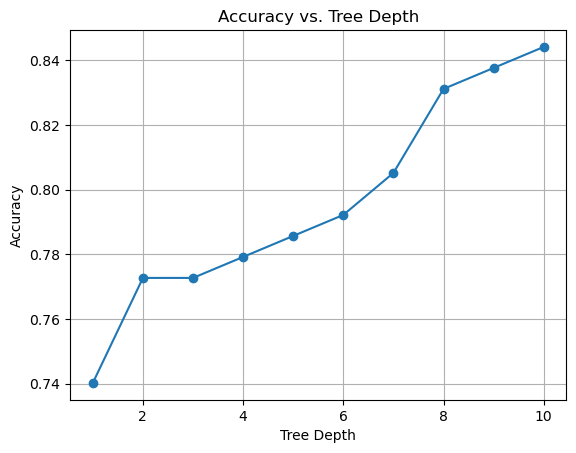

Test Accuracy: 0.7857142857142857


In [15]:
tree = id3(X_train, y_train, max_depth=5)
reduced_error_pruning(tree, X_test, y_test)
plot_accuracy_vs_depth(X_train, y_train, X_test, y_test)
test_accuracy = evaluate_model(tree, X_test, y_test)
print("Test Accuracy:", test_accuracy)

In [16]:
feature_names = df.columns[:-1]  # Assuming the last column is the target
print("Pruned Decision Tree:")
print_tree(tree, feature_names)

Pruned Decision Tree:
Split on feature Glucose (Threshold: 0.19197597627987598)
  Split on feature Age (Threshold: -0.42693042854827923)
    Split on feature BMI (Threshold: -0.14007537218652463)
    Class: 0
    Split on feature BMI (Threshold: -0.7477565343270397)
      Split on feature BMI (Threshold: -4.135255778599698)
        Class: 1
        Class: 0
      Split on feature Glucose (Threshold: -0.8389853890482045)
        Split on feature Glucose (Threshold: -3.775663217558494)
        Class: 0
        Split on feature DiabetesPedigreeFunction (Threshold: 0.1272601563924316)
          Class: 0
          Class: 1
  Split on feature BMI (Threshold: -0.2693692364717406)
    Split on feature Glucose (Threshold: 0.7543185391861017)
    Class: 0
    Split on feature Glucose (Threshold: 1.379143609081908)
    Class: 1


In [17]:
y_pred = [predict_tree(tree, x) for x in X_test]
macro_accuracy = accuracy_score(y_test, y_pred)
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
print(f"Mean Macro Accuracy: {macro_accuracy}")
print(f"Mean Macro Precision: {macro_precision}")
print(f"Mean Macro Recall: {macro_recall}")

Mean Macro Accuracy: 0.7857142857142857
Mean Macro Precision: 0.7668518518518519
Mean Macro Recall: 0.7646464646464646
